In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=3, bias=False)
    self.conv2 = nn.Conv2d(10, 10, kernel_size=3, bias=False)
    self.conv3 = nn.Conv2d(10, 20, kernel_size=3, bias=False)
    self.conv4 = nn.Conv2d(20, 20, kernel_size=3, bias=False)
    self.conv5 = nn.Conv2d(20, 30, kernel_size=3, bias=False)
    self.max_pool = nn.MaxPool2d(2,2)
    self.conv6 = nn.Conv2d(30, 62, kernel_size=3, bias=False)
    self.GAP = nn.AvgPool2d(4)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    
  def forward(self, x):
    x = self.max_pool(self.dropout(self.relu(self.conv2(self.dropout(self.relu(self.conv1(x)))))))
    x = self.dropout(self.relu(self.conv4(self.dropout(self.relu(self.conv3(x))))))
    x = self.relu(self.conv5(x))
    x = self.GAP(self.conv6(x))
    #x = x.view(-1, 10)
    #print(x.shape)
    return F.log_softmax(x) 

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
           Dropout-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
           Dropout-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 20, 10, 10]           1,800
              ReLU-9           [-1, 20, 10, 10]               0
          Dropout-10           [-1, 20, 10, 10]               0
           Conv2d-11             [-1, 20, 8, 8]           3,600
             ReLU-12             [-1, 20, 8, 8]               0
          Dropout-13             [-1, 20, 8, 8]               0
           Conv2d-14             [-1, 3

In [4]:
train_set = datasets.EMNIST(
    root="./data",
    train=True,
    download=True,
    split="byclass",
    transform=transforms.Compose(
        [
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
test_set = datasets.EMNIST(
    root="./data",
    train=False,
    download=True,
    split="byclass",
    transform=transforms.Compose(
        [
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ]
    ),
)

In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

tensor([ 6, 12,  2,  3,  5, 47,  1,  1,  1, 38, 22, 19,  6, 35,  3,  5, 55,  3,
         0, 47,  2, 55, 24,  4,  0, 47,  2,  2,  7,  0,  6, 40])


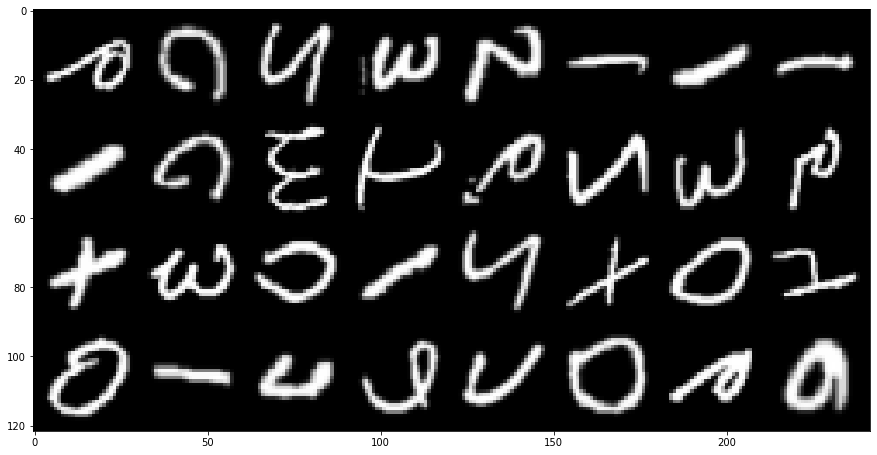

In [6]:
batch = next(iter(train_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=8)
plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1,2,0)))
print(labels)


In [7]:
from tqdm import tqdm
from functools import partial

tqdm = partial(tqdm, leave=True, position=0)
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    print('starting')
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output.view(32, -1), target)
        loss.backward()
        optimizer.step()
    print('done with one epoch')
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
       

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(enumerate(test_loader), total=len(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.view(32, -1), target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [95]:
torch.randn((32,62,1,1)).squeeze().shape

torch.Size([32, 62])

In [ ]:

optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    print(f'EPOCH {epoch} / 10')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)